In [2]:
original_sids = sorted(['KCAT', 'WSFT', 'WW2T', 'TS6T', 'FMFT', 'HCBT', 'PF5T', 'LV2T', 'UM2T', 'MRCT', 'RSIT', 'KP6T', 'NM3T', 'BI3T', 'SC1T', 'SPGT', 'ZK4T', 'GAIT', 'DA9T', 'VL1T'])
len(original_sids)

bias_sids = ['PF5T', 'WW2T', 'WSFT', 'KP6T', 'LV2T', 'FMFT', 'HCBT', 'RSIT', 'TS6T', 'UM2T', 'MRCT', 'NM3T', 'SPGT', 'ZK4T', 'GAIT', 'DA9T', 'VL1T', 'BI3T', 'KCAT']
len(np.unique(bias_sids))

19

In [3]:
def get_convert_matrix(subject_id):
    original_sids = sorted(['KCAT', 'WSFT', 'WW2T', 'TS6T', 'FMFT', 'HCBT', 'PF5T', 'LV2T', 'UM2T', 'MRCT', 'RSIT', 'KP6T', 'NM3T', 'BI3T', 'SC1T', 'SPGT', 'ZK4T', 'GAIT', 'DA9T', 'VL1T'])
    len(original_sids)
    idx = original_sids.index(subject_id)
    return '/home/gdholla1/data/ERC_FLASH_template_ants/composite_transform_5_iterations/_register_5{idx}/transformComposite.h5'.format(idx=idx)

In [1]:
import nipype.pipeline.engine as pe
from nipype.interfaces import utility as util
from nipype.interfaces import ants
from nipype.interfaces import io as nio

In [5]:
workflow = pe.Workflow(name='make_flash_masks', base_dir='/home/gdholla1/workflow_folders/')

identity = pe.Node(util.IdentityInterface(fields=['subject_id']), name='identity')

identity.iterables = [('subject_id', bias_sids)]

templates = {'mask':'/home/gdholla1/data/stop3/masks/original_space/conjunct_masks_2std/{subject_id}_{mask}.nii.gz'}
selector = pe.Node(nio.SelectFiles(templates), name='selector')
selector.iterables = [('mask', ['STh_L', 'STh_R'])]

get_matrix = pe.Node(util.Function(input_names=['subject_id'], output_names=['transformation'], function=get_convert_matrix),
                     name='get_matrix')

apply_transform = pe.Node(ants.ApplyTransforms(), name='apply_transform')
apply_transform.inputs.reference_image = '/home/gdholla1/data/ERC_FLASH_template_ants/template_5_iterations/transform_Warped_merged_mean.nii.gz'
apply_transform.inputs.interpolation = 'NearestNeighbor'

workflow.connect(identity, 'subject_id', selector, 'subject_id')
workflow.connect(identity, 'subject_id', get_matrix, 'subject_id')

workflow.connect(selector, 'mask', apply_transform, 'input_image')
workflow.connect(get_matrix, 'transformation', apply_transform, 'transforms')

ds = pe.Node(nio.DataSink(), name='datasink')
ds.inputs.base_directory = '/home/gdholla1/projects/bias/data/FLASH_group_space/'

workflow.connect(apply_transform, 'output_image', ds, 'individual_masks_in_group_space')

workflow.run()

# Do PCA

In [7]:
import nibabel as nb



## Left STN

In [8]:
fns = ['/home/gdholla1/projects/bias/data/FLASH_group_space/individual_masks_in_group_space/_subject_id_{}/_mask_STh_L/{}_STh_L_trans.nii.gz'.format(subject_id, subject_id) for subject_id in bias_sids]

In [9]:
images = [nb.load(fn) for fn in fns]
masks = [image.get_data() for image in images]

In [10]:
threshold = 0.9 * len(masks)

In [11]:
summed_masks =  np.sum(masks, 0)
x, y, z = np.where((summed_masks > threshold))

import pandas
coords = pandas.DataFrame({'x':x, 'y':y, 'z':z})
coords -= coords.mean()

from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca.fit(coords)

# Make sure it goes inferior
if pca.components_[0, -1] > 0:
    pca.components_ *= -1

left_stn_pca = pca.components_


transformed_coordinates = pca.transform(np.array(np.where(np.ones_like(summed_masks))).T)
new_data = transformed_coordinates.ravel() + transformed_coordinates.min() + 1
new_data = new_data.reshape(summed_masks.shape)

nb.save(nb.Nifti1Image(new_data, images[0].affine), '/home/gdholla1/projects/bias/data/FLASH_group_space/stn_l_pca.nii.gz')
nb.save(nb.Nifti1Image(summed_masks, images[0].affine), '/home/gdholla1/projects/bias/data/FLASH_group_space/group_stn_l.nii.gz')

# Right STN

In [12]:
fns = ['/home/gdholla1/projects/bias/data/FLASH_group_space/individual_masks_in_group_space/_subject_id_{}/_mask_STh_R/{}_STh_R_trans.nii.gz'.format(subject_id, subject_id) for subject_id in bias_sids]

In [13]:
images = [nb.load(fn) for fn in fns]
masks = [image.get_data() for image in images]

In [14]:
summed_masks =  np.sum(masks, 0)
x, y, z = np.where((summed_masks > threshold))

import pandas
coords = pandas.DataFrame({'x':x, 'y':y, 'z':z})
coords -= coords.mean()

from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca.fit(coords)

# Make sure it goes inferior
if pca.components_[0, -1] > 0:
    pca.components_ *= -1

right_stn_pca = pca.components_




transformed_coordinates = pca.transform(np.array(np.where(np.ones_like(summed_masks))).T)
new_data = transformed_coordinates.ravel() + transformed_coordinates.min() + 1
new_data = new_data.reshape(summed_masks.shape)

nb.save(nb.Nifti1Image(new_data, images[0].affine), '/home/gdholla1/projects/bias/data/FLASH_group_space/stn_r_pca.nii.gz')
nb.save(nb.Nifti1Image(summed_masks, images[0].affine), '/home/gdholla1/projects/bias/data/FLASH_group_space/group_stn_r.nii.gz')

# Visualize PCA

In [15]:
group_image = nb.load('/home/gdholla1/data/ERC_FLASH_template_ants/template_5_iterations/transform_Warped_merged_mean.nii.gz').get_data()

left_stn = nb.load('/home/gdholla1/projects/bias/data/FLASH_group_space/group_stn_l.nii.gz').get_data()
right_stn = nb.load('/home/gdholla1/projects/bias/data/FLASH_group_space/group_stn_r.nii.gz').get_data()

pca_map_stn_l = nb.load('/home/gdholla1/projects/bias/data/FLASH_group_space/stn_l_pca.nii.gz').get_data()
pca_map_stn_r = nb.load('/home/gdholla1/projects/bias/data/FLASH_group_space/stn_r_pca.nii.gz').get_data()


In [17]:
import scipy as sp
from scipy import ndimage

In [18]:
com_l = ndimage.center_of_mass(left_stn)

In [19]:
com_l

(132.84671884406984, 176.98892233594219, 61.57664057796508)

(170, 190)

/usr/local/lib/python2.7/dist-packages/matplotlib/colors.py:943: UserWarning: Warning: converting a masked element to nan.
  vmin = float(vmin)
/usr/local/lib/python2.7/dist-packages/matplotlib/colors.py:944: UserWarning: Warning: converting a masked element to nan.
  vmax = float(vmax)


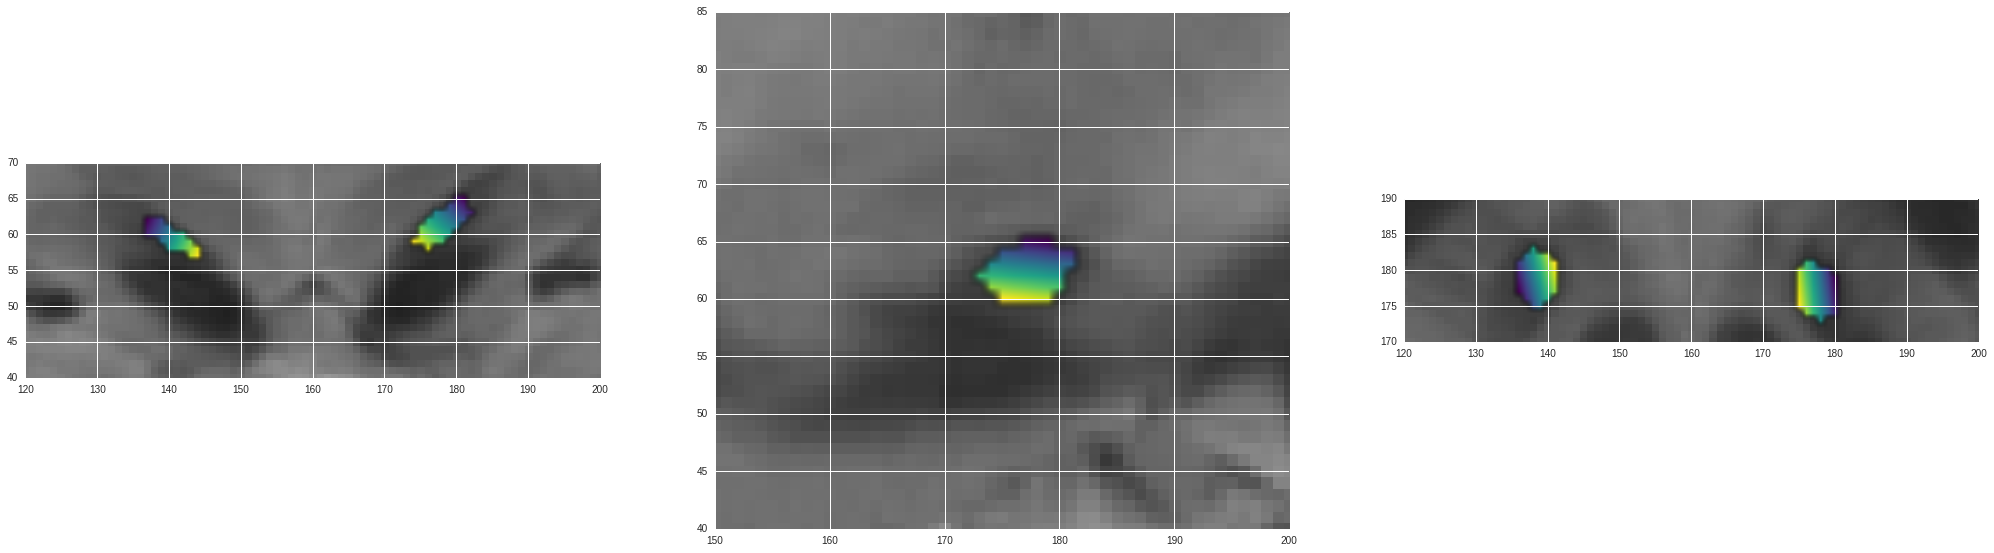

In [21]:
pca_map_stn_l_masked = pca_map_stn_l.copy()
pca_map_stn_l_masked[left_stn < 14] = 0
pca_map_stn_l_masked = np.ma.masked_equal(pca_map_stn_l_masked, 0)

pca_map_stn_r_masked = pca_map_stn_r.copy()
pca_map_stn_r_masked[right_stn < 14] = 0
pca_map_stn_r_masked = np.ma.masked_equal(pca_map_stn_r_masked, 0)


plt.figure(figsize=(35, 10))
plt.subplot(131)
plt.imshow(group_image[::-1, 176, :].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.imshow(pca_map_stn_l_masked[::-1, 176, :].T, origin='lower', cmap=plt.cm.viridis)
plt.imshow(pca_map_stn_r_masked[::-1, 176, :].T, origin='lower', cmap=plt.cm.viridis)
plt.xlim(120, 200)
plt.ylim(40, 70)

plt.subplot(132)
plt.imshow(group_image[132, :, :].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.imshow(pca_map_stn_l_masked[132, :, :].T, origin='lower', cmap=plt.cm.viridis)
plt.imshow(pca_map_stn_r_masked[132, :, :].T, origin='lower', cmap=plt.cm.viridis)
plt.xlim(150, 200)
plt.ylim(40, 85)


plt.subplot(133)
plt.imshow(group_image[::-1, :, 61].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.imshow(pca_map_stn_l_masked[::-1, :, 61].T, origin='lower', cmap=plt.cm.viridis)
plt.imshow(pca_map_stn_r_masked[::-1, :, 61].T, origin='lower', cmap=plt.cm.viridis)
plt.xlim(120, 200)
plt.ylim(170, 190)

# Get STN PCA map in individual space

In [6]:
transformer.outputs


output_image = <undefined>

In [5]:
workflow = pe.Workflow(name='PCA_to_indidivual_FLASH')
workflow.base_dir = '/home/gdholla1/projects/bias/workflow_folders/'

templates = {'pca':'/home/gdholla1/projects/bias/data/FLASH_group_space/stn_{hemisphere}_pca.nii.gz',
             'transformation_matrix':'/home/gdholla1/projects/bias/data/FLASH_group_space/sub-{subject_id}/sub-{subject_id}_group2flash.h5',
             'mean_flash':'/home/gdholla1/projects/bias/data/derivatives/sub-{subject_id}/mean_flash/sub-{subject_id}_FLASH_echo_11.22_merged_mean_brain.nii.gz'}

selector = pe.Node(nio.SelectFiles(templates), name='selector')
selector.iterables = [('subject_id', ['%02d' % i for i in np.arange(1, 20)]), ('hemisphere', ['l', 'r'])]

transformer = pe.Node(ants.ApplyTransforms(), name='applier')
workflow.connect(selector, 'pca', transformer, 'input_image')
workflow.connect(selector, 'transformation_matrix', transformer, 'transforms')
workflow.connect(selector, 'mean_flash', transformer, 'reference_image')

ds = pe.Node(nio.DataSink(), name='datasink')
ds.inputs.base_directory = '/home/gdholla1/projects/bias/data/derivatives/PCA_segments'
workflow.connect(transformer, 'output_image', ds, 'pca_in_FLASH')

ds.inputs.regexp_substitutions = [('_hemisphere_[a-z]_subject_id_([0-9]+)/', 'sub-\\1/sub-\\1_')]

workflow.run()

In [117]:
from nipype.interfaces import fsl

# Make individual sub-STN-masks

In [7]:
import nibabel as nb

In [10]:
import scipy as sp
from scipy import ndimage

In [70]:
for subj_idx in ['%02d' % i for i in np.arange(1, 20)]:
    
    print subj_idx


    ## *** Left stn ***
    pca_left_stn = nb.load('/home/gdholla1/projects/bias/data/derivatives/PCA_segments/pca_in_FLASH/sub-{subj_idx}/sub-{subj_idx}_stn_l_pca_trans.nii.gz'.format(**locals()))
    left_stn = nb.load('/home/gdholla1/projects/bias/data/derivatives/sub-{subj_idx}/masks/FLASH_space/sub-{subj_idx}_mask-STh_L.nii.gz'.format(**locals()))

    com = ndimage.center_of_mass(left_stn.get_data())
    pca_values = pca_left_stn.get_data()[left_stn.get_data() > 0]

    pca_values_3d = np.ones_like(left_stn.get_data()) * np.nan
    pca_values_3d[left_stn.get_data() > 0] = pca_values

    segment_a = np.zeros_like(left_stn.get_data())
    segment_a = (left_stn.get_data() > 0) & (pca_values_3d < np.nanpercentile(pca_values_3d, 100 / 3.))

    segment_b = np.zeros_like(left_stn.get_data())
    segment_b = (left_stn.get_data() > 0) & (pca_values_3d >= np.nanpercentile(pca_values_3d, 100 / 3.))   & (pca_values_3d < np.nanpercentile(pca_values_3d, 2 * 100 / 3.))

    segment_c = np.zeros_like(left_stn.get_data())
    segment_c = (left_stn.get_data() > 0) & (pca_values_3d >= np.nanpercentile(pca_values_3d, 2 * 100 / 3.))

    print segment_a.sum(), segment_b.sum(), segment_c.sum()

    nb.save(nb.Nifti1Image(segment_a.astype(float), left_stn.affine, left_stn.header), '/home/gdholla1/projects/bias/data/derivatives/sub-{subj_idx}/masks/FLASH_space/sub-{subj_idx}_mask-STh_L_A.nii.gz'.format(**locals()))
    nb.save(nb.Nifti1Image(segment_b.astype(float), left_stn.affine, left_stn.header), '/home/gdholla1/projects/bias/data/derivatives/sub-{subj_idx}/masks/FLASH_space/sub-{subj_idx}_mask-STh_L_B.nii.gz'.format(**locals()))
    nb.save(nb.Nifti1Image(segment_c.astype(float), left_stn.affine, left_stn.header), '/home/gdholla1/projects/bias/data/derivatives/sub-{subj_idx}/masks/FLASH_space/sub-{subj_idx}_mask-STh_L_C.nii.gz'.format(**locals()))

    ## *** Right stn ***
    pca_right_stn = nb.load('/home/gdholla1/projects/bias/data/derivatives/PCA_segments/pca_in_FLASH/sub-{subj_idx}/sub-{subj_idx}_stn_r_pca_trans.nii.gz'.format(**locals()))
    right_stn = nb.load('/home/gdholla1/projects/bias/data/derivatives/sub-{subj_idx}/masks/FLASH_space/sub-{subj_idx}_mask-STh_R.nii.gz'.format(**locals()))

    com = ndimage.center_of_mass(right_stn.get_data())
    pca_values = pca_right_stn.get_data()[right_stn.get_data() > 0]

    pca_values_3d = np.ones_like(right_stn.get_data()) * np.nan
    pca_values_3d[right_stn.get_data() > 0] = pca_values

    segment_a = np.zeros_like(right_stn.get_data())
    segment_a = (right_stn.get_data() > 0) & (pca_values_3d < np.nanpercentile(pca_values_3d, 100 / 3.))

    segment_b = np.zeros_like(right_stn.get_data())
    segment_b = (right_stn.get_data() > 0) & (pca_values_3d >= np.nanpercentile(pca_values_3d, 100 / 3.))   & (pca_values_3d < np.nanpercentile(pca_values_3d, 2 * 100 / 3.))

    segment_c = np.zeros_like(right_stn.get_data())
    segment_c = (right_stn.get_data() > 0) & (pca_values_3d >= np.nanpercentile(pca_values_3d, 2 * 100 / 3.))

    print segment_a.sum(), segment_b.sum(), segment_c.sum()

    nb.save(nb.Nifti1Image(segment_a.astype(float), right_stn.affine, right_stn.header), '/home/gdholla1/projects/bias/data/derivatives/sub-{subj_idx}/masks/FLASH_space/sub-{subj_idx}_mask-STh_R_A.nii.gz'.format(**locals()))
    nb.save(nb.Nifti1Image(segment_b.astype(float), right_stn.affine, right_stn.header), '/home/gdholla1/projects/bias/data/derivatives/sub-{subj_idx}/masks/FLASH_space/sub-{subj_idx}_mask-STh_R_B.nii.gz'.format(**locals()))
    nb.save(nb.Nifti1Image(segment_c.astype(float), right_stn.affine, right_stn.header), '/home/gdholla1/projects/bias/data/derivatives/sub-{subj_idx}/masks/FLASH_space/sub-{subj_idx}_mask-STh_R_C.nii.gz'.format(**locals()))

01


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in greater_equal


202 202 203


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in greater_equal


207 206 207
02
147 147 147
197 197 197
03
152 152 152
188 188 189
04
130 130 131
155 155 155
05
131 131 132
137 137 137
06
145 145 145
137 137 138
07
144 144 144
149 149 150
08
74 74 74
160 160 160
09
167 166 167
205 205 205
10
146 146 146
187 187 188
11
172 172 172
150 150 151
12
106 106 106
132 132 133
13
149 149 149
116 116 117
14
106 105 106
121 121 122
15
82 81 82
108 108 109
16
130 130 130
103 103 103
17
159 159 159
136 135 136
18
214 214 214
175 175 175
19
154 154 155
209 209 209


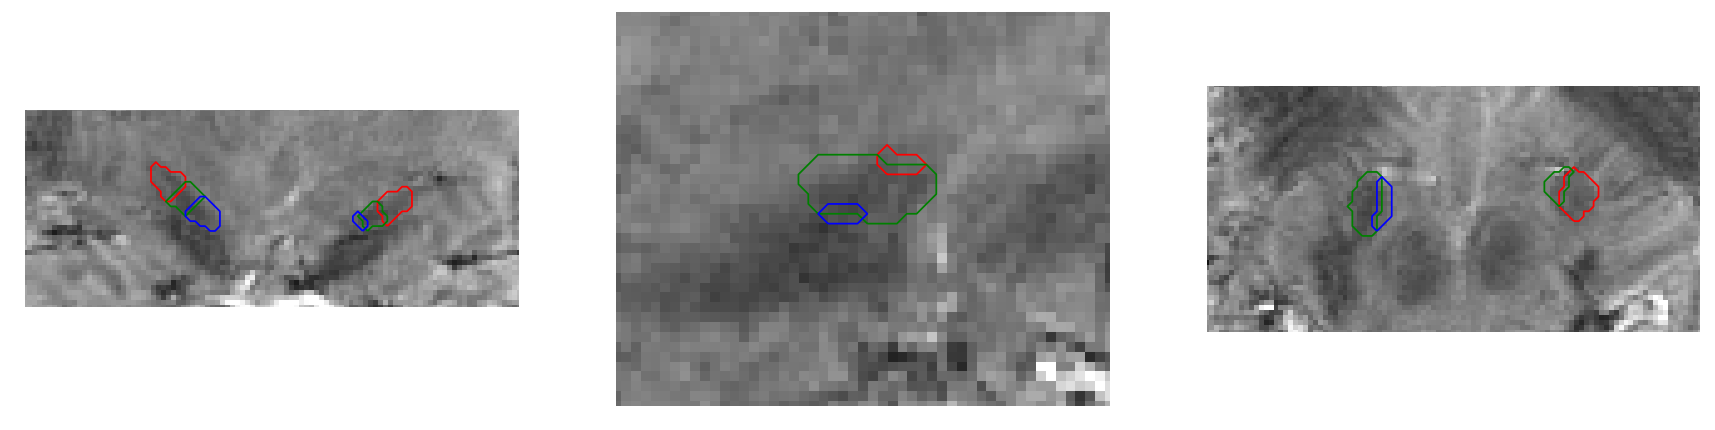

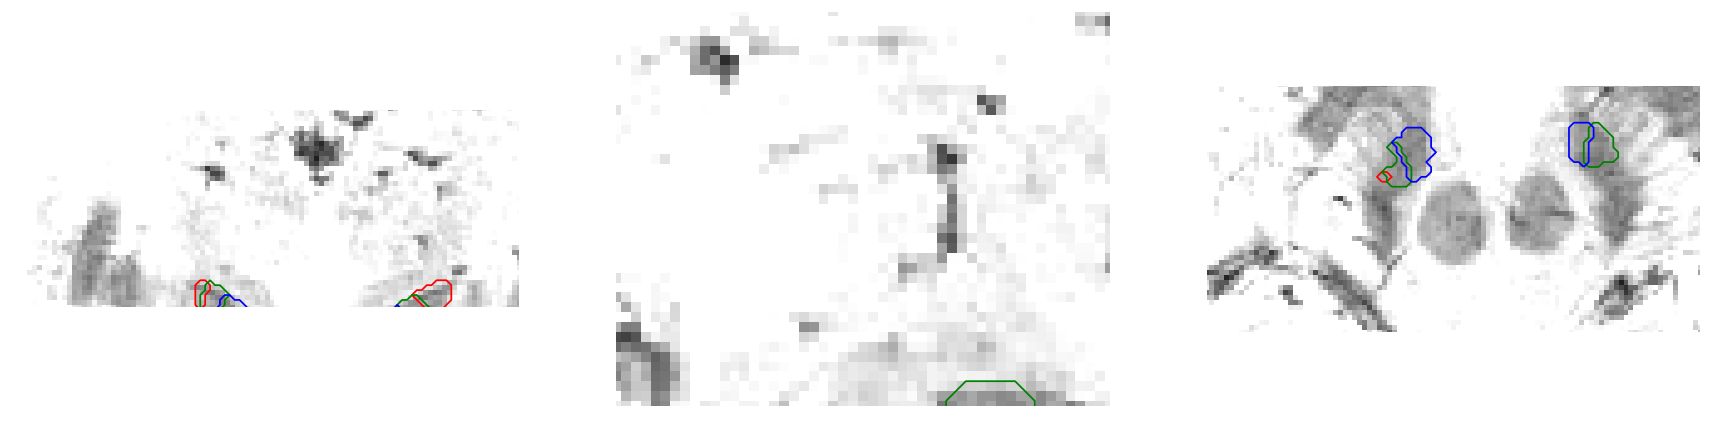

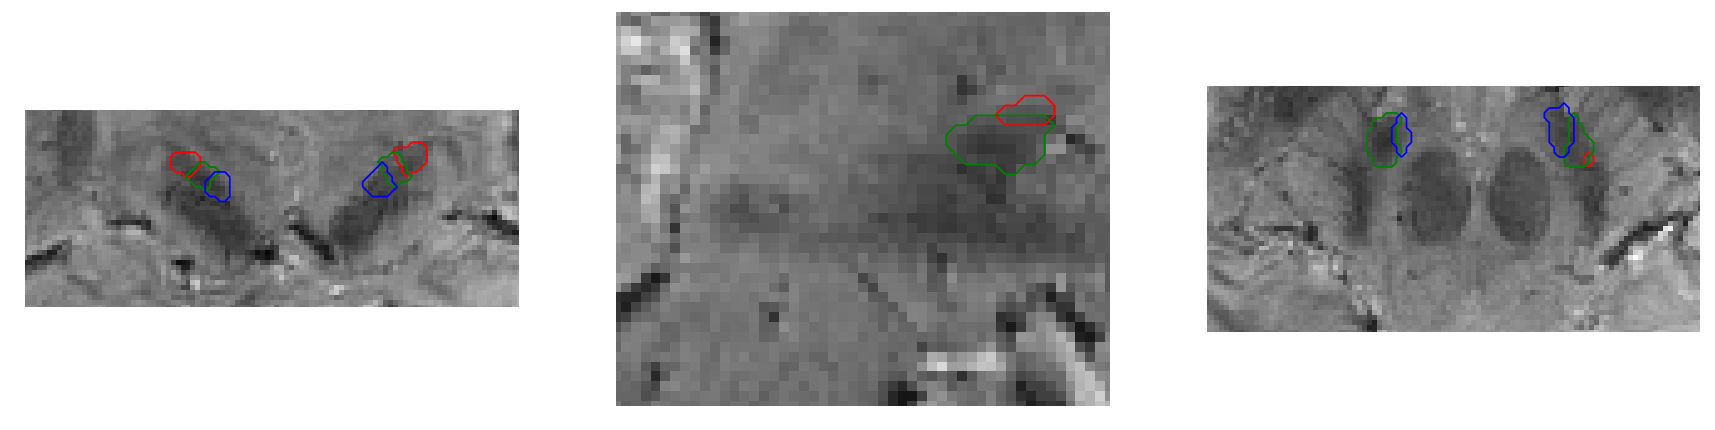

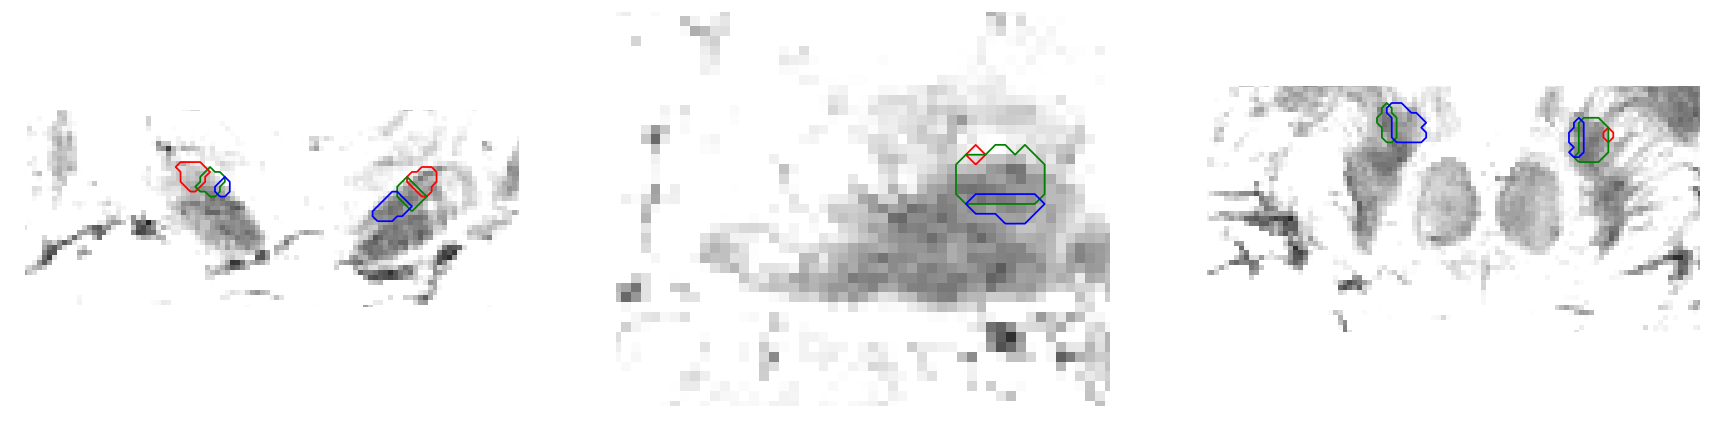

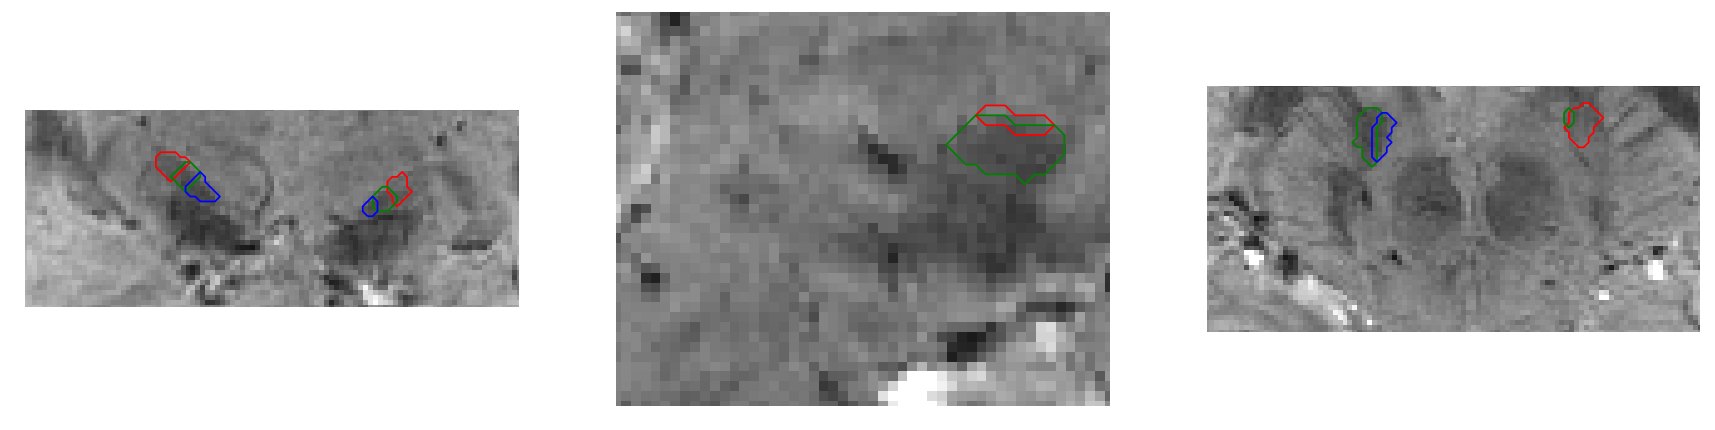

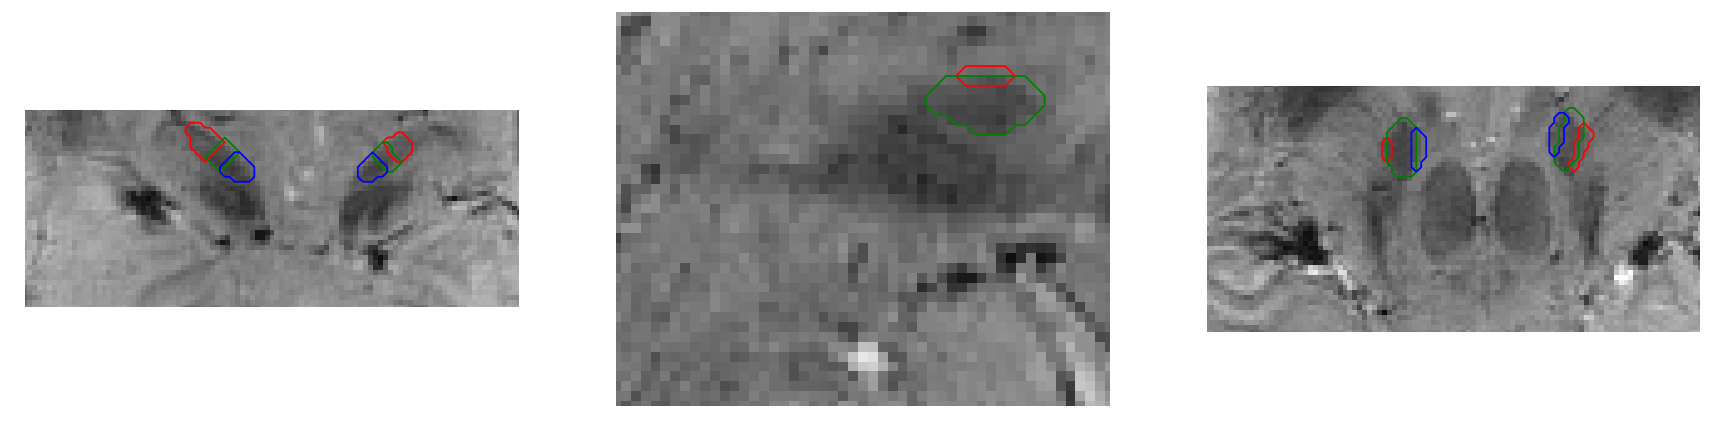

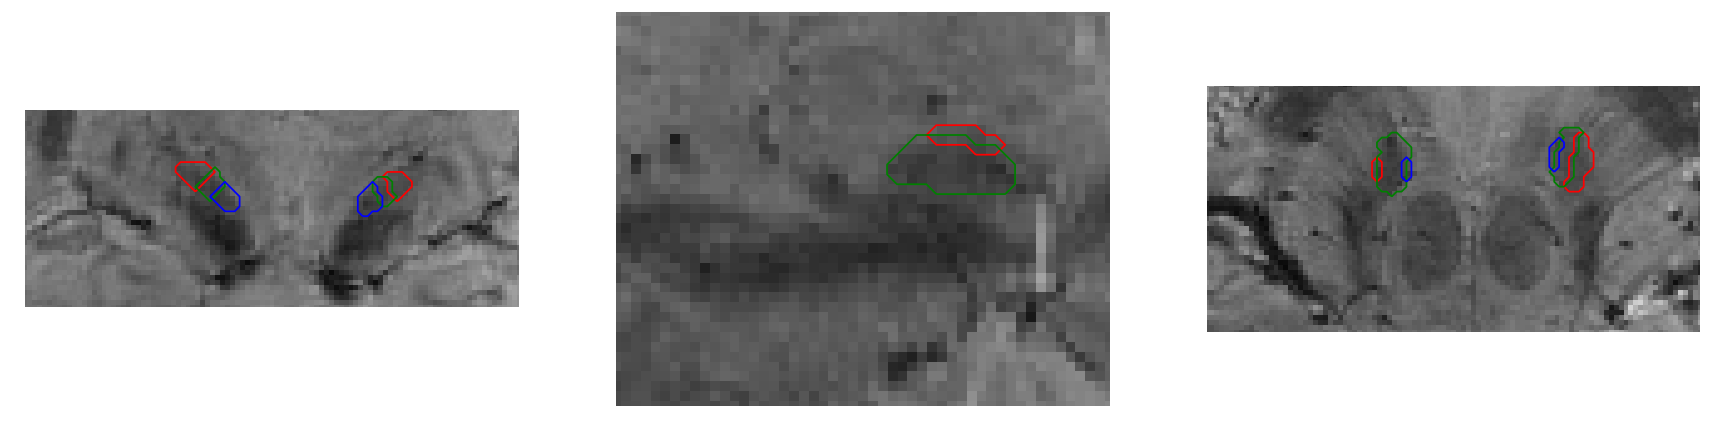

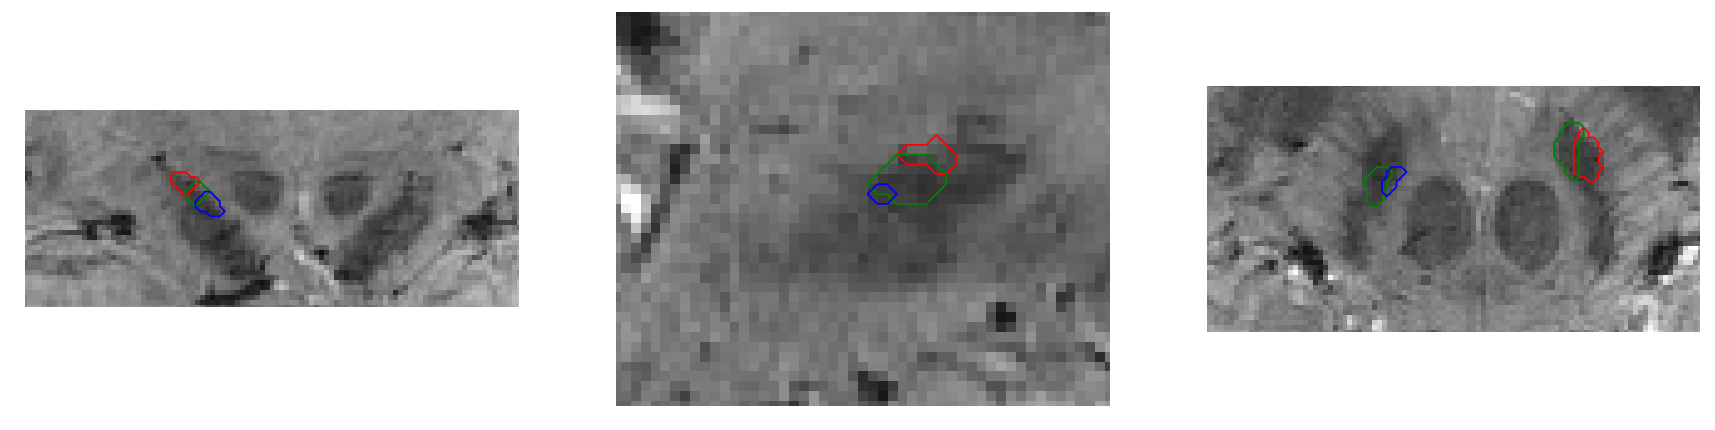

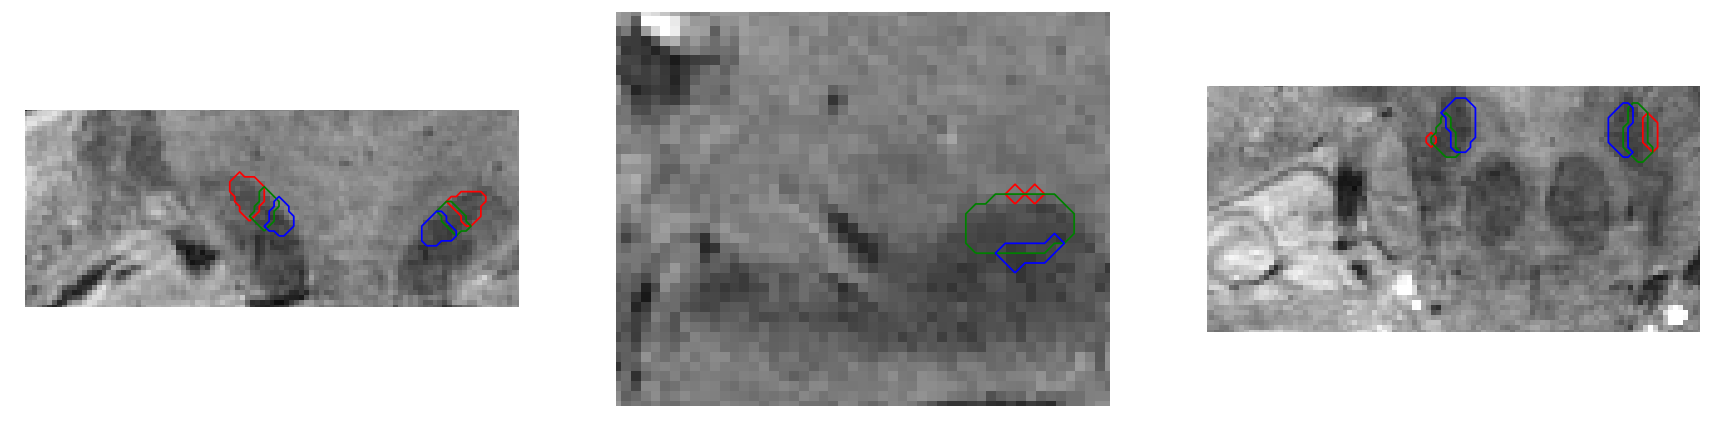

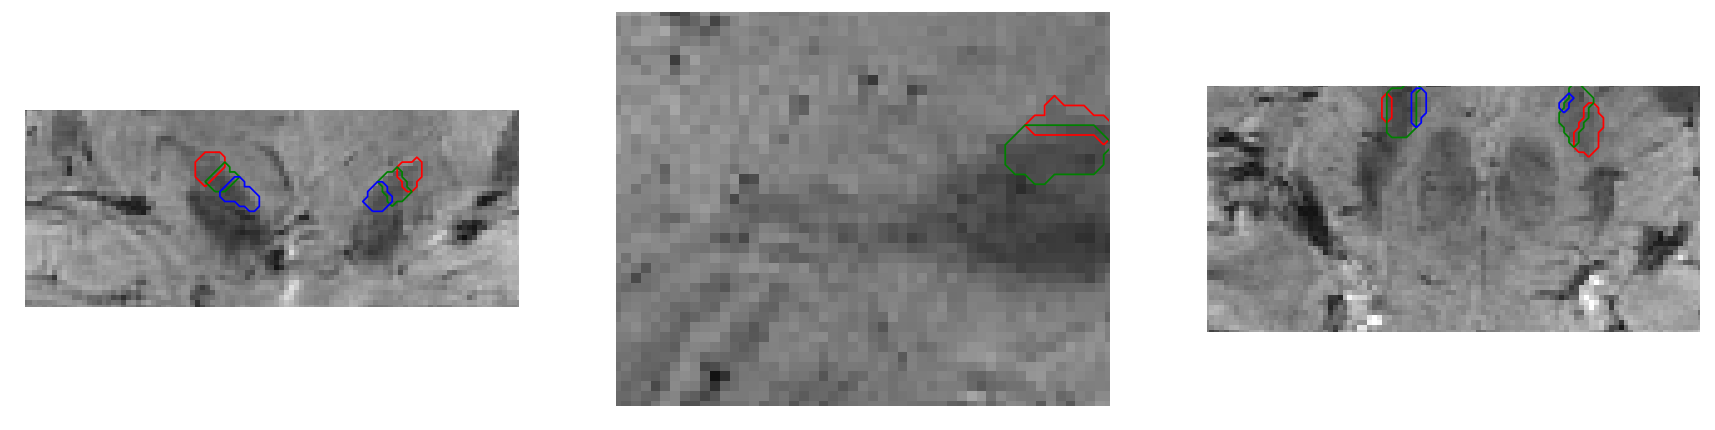

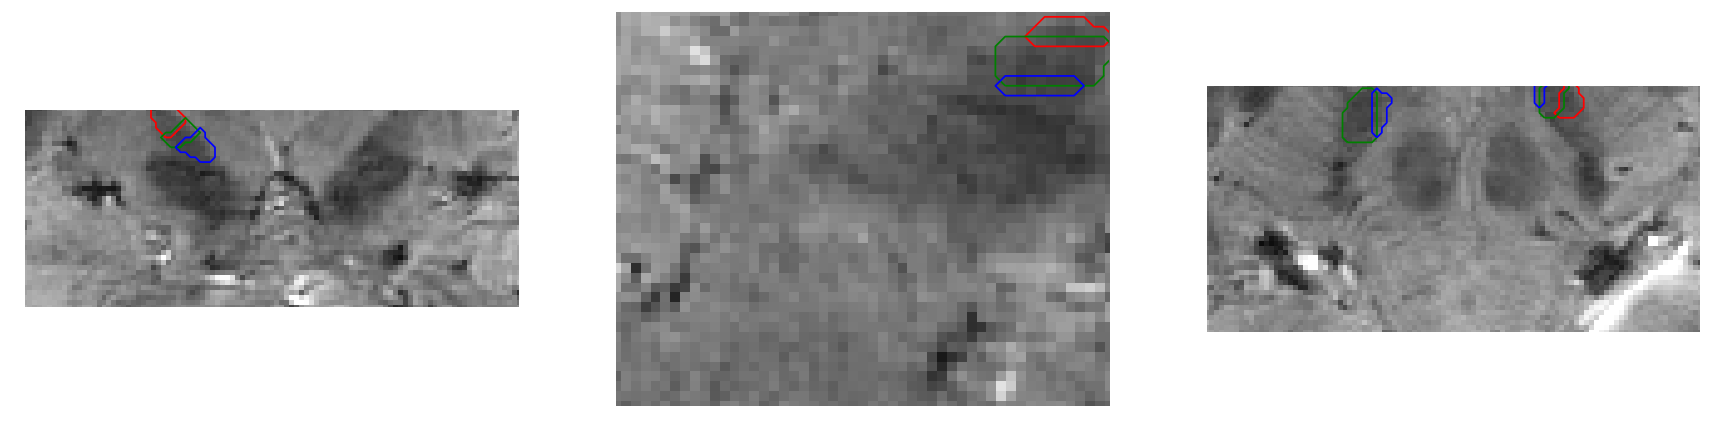

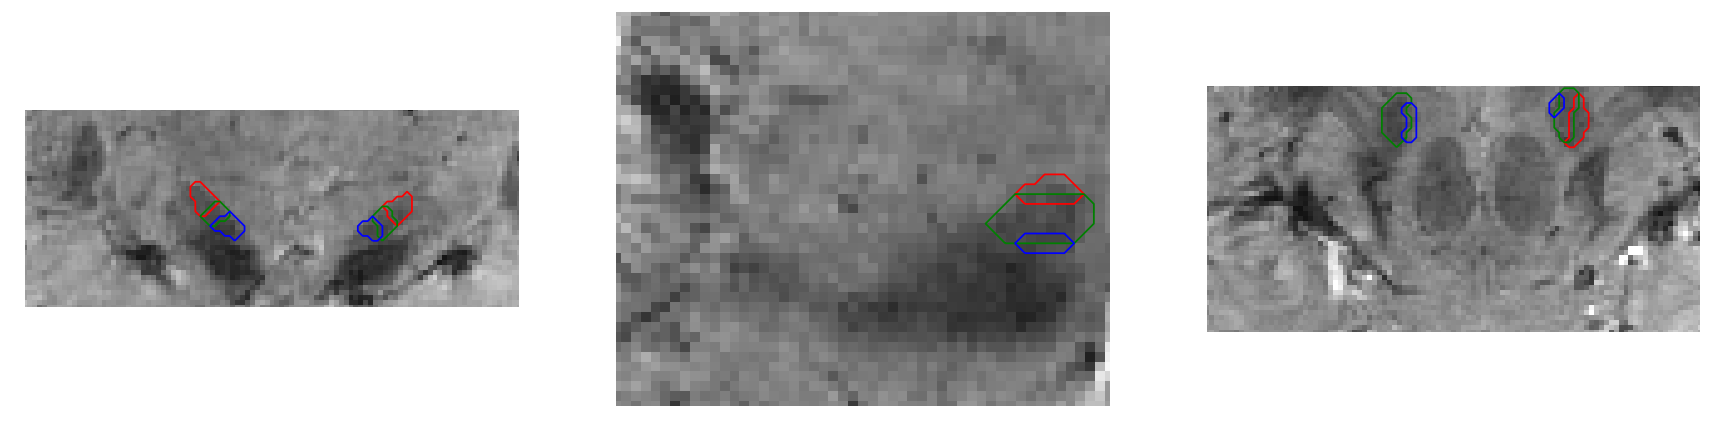

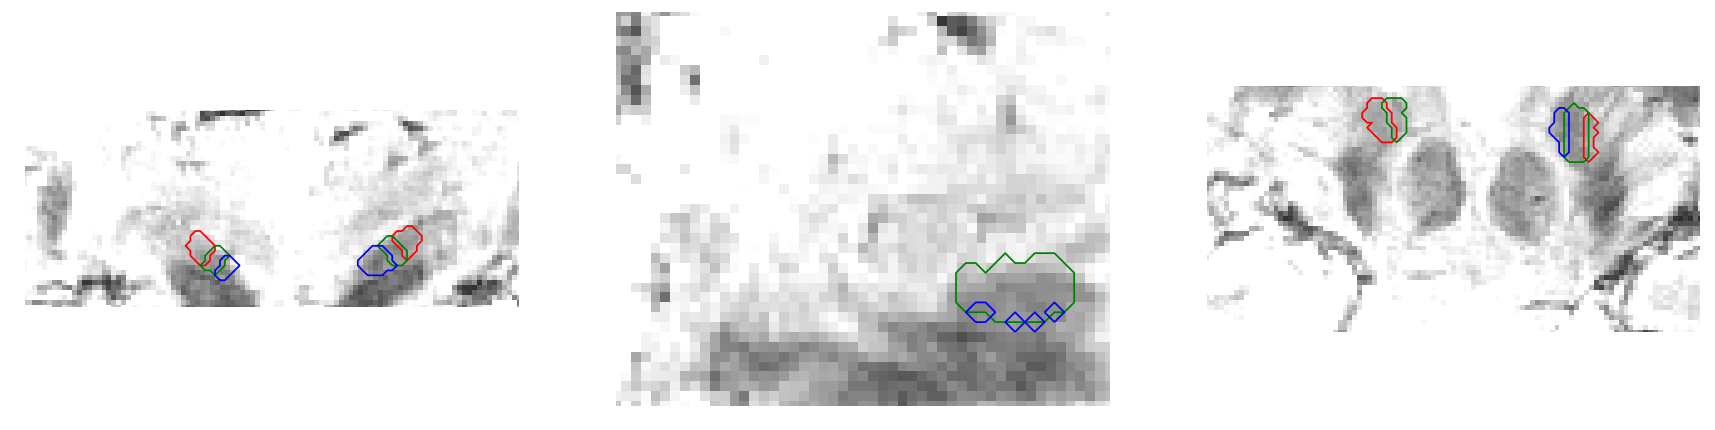

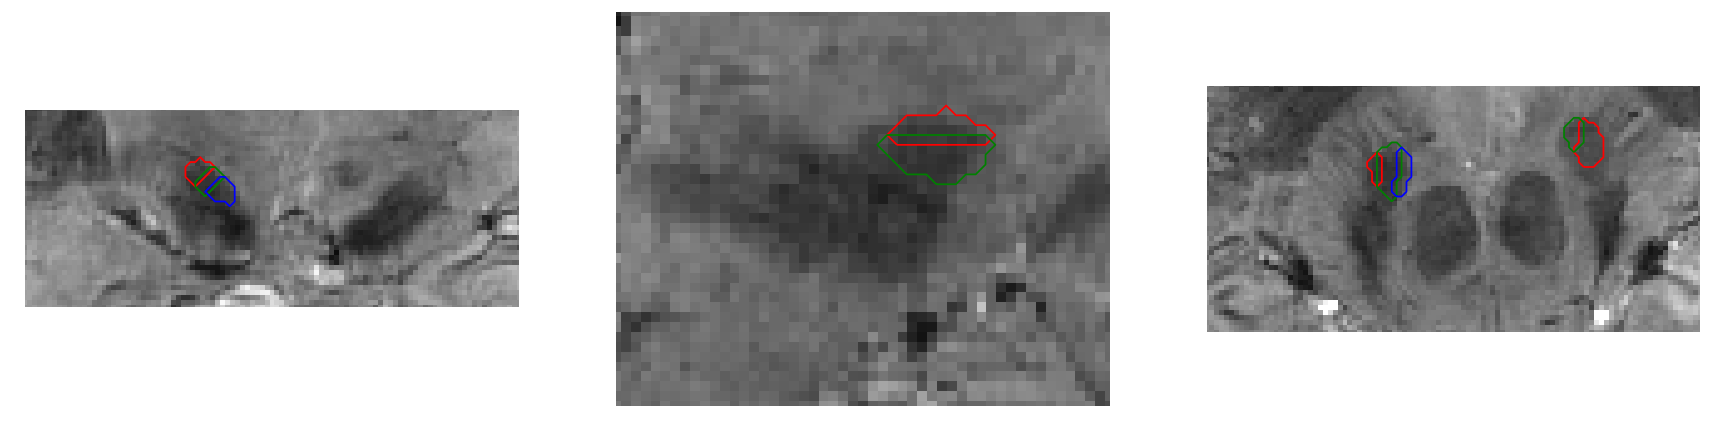

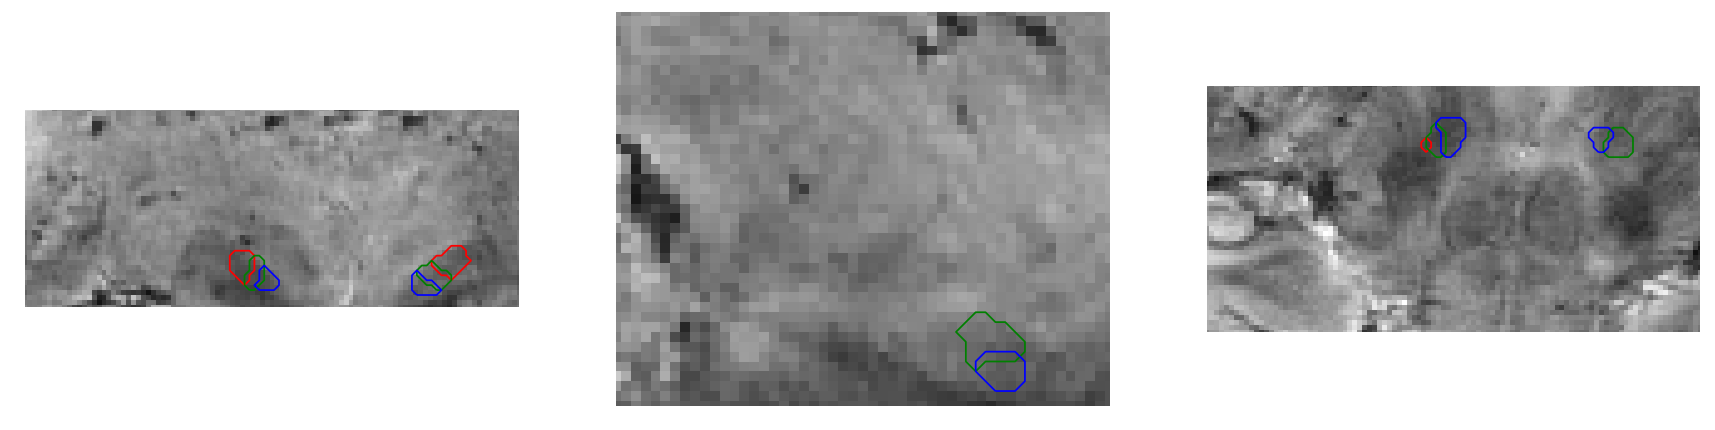

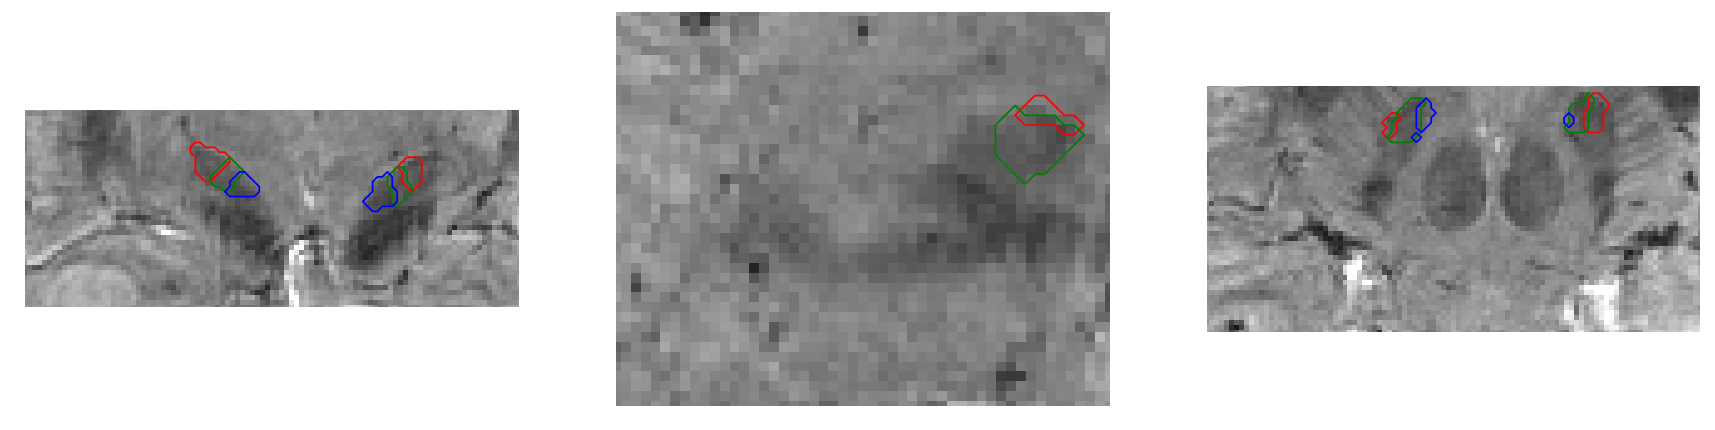

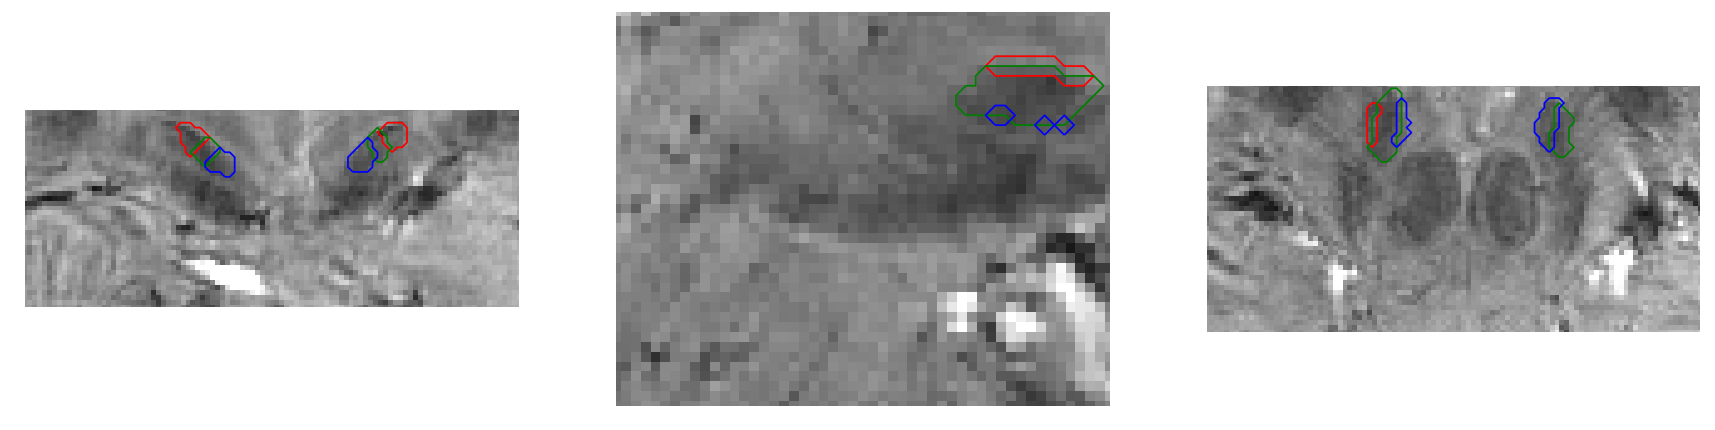

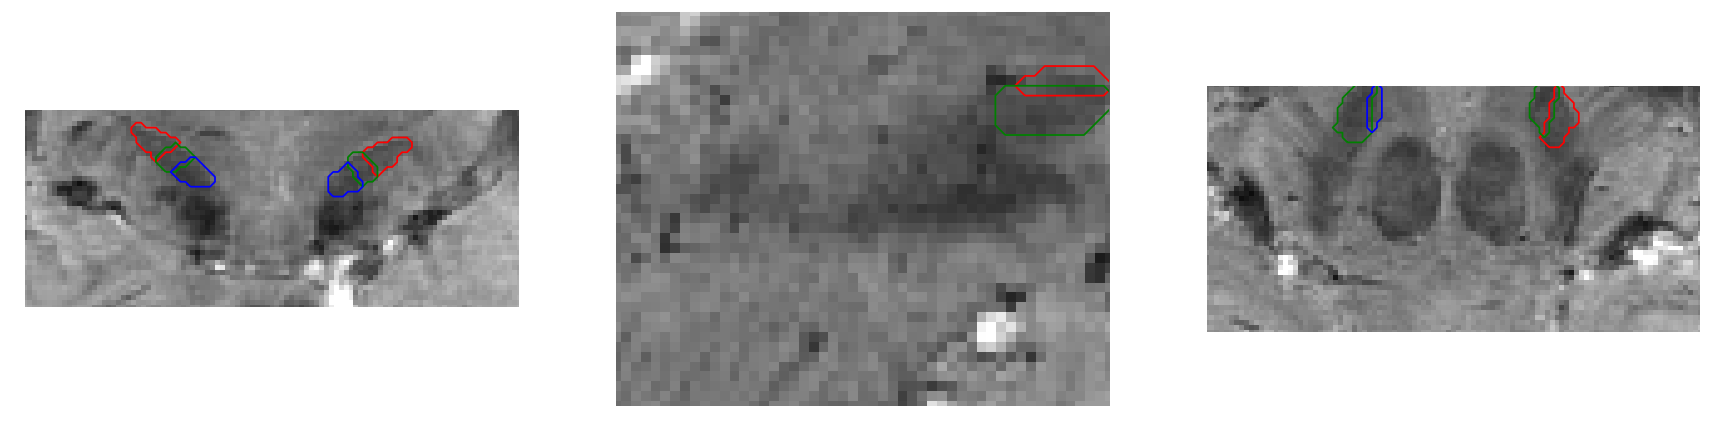

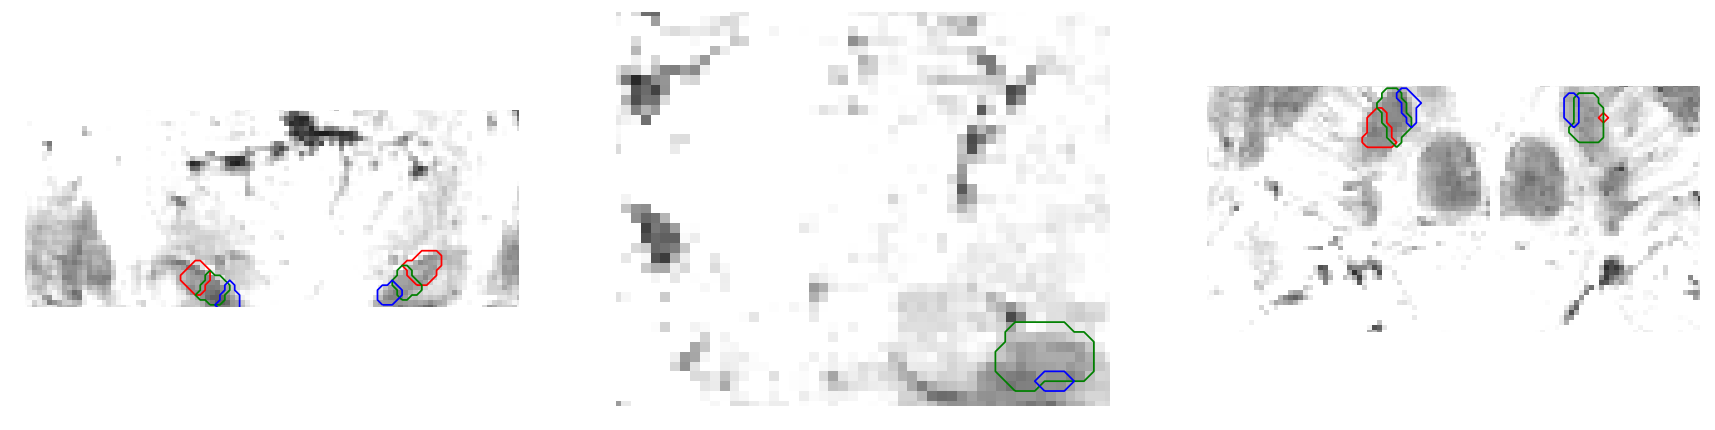

In [90]:
for subj_idx in ['%02d' % i for i in np.arange(1, 20)][:]:
    mean_flash = nb.load('/home/gdholla1/projects/bias/data/derivatives/sub-{subj_idx}/mean_flash/sub-{subj_idx}_FLASH_echo_11.22_merged_mean_brain.nii.gz'.format(**locals()))
    
    left_stn = nb.load('/home/gdholla1/projects/bias/data/derivatives/sub-{subj_idx}/masks/FLASH_space/sub-{subj_idx}_mask-STh_L.nii.gz'.format(**locals()))
    segment_a_l = nb.load('/home/gdholla1/projects/bias/data/derivatives/sub-{subj_idx}/masks/FLASH_space/sub-{subj_idx}_mask-STh_L_A.nii.gz'.format(**locals()))
    segment_b_l = nb.load('/home/gdholla1/projects/bias/data/derivatives/sub-{subj_idx}/masks/FLASH_space/sub-{subj_idx}_mask-STh_L_B.nii.gz'.format(**locals()))
    segment_c_l = nb.load('/home/gdholla1/projects/bias/data/derivatives/sub-{subj_idx}/masks/FLASH_space/sub-{subj_idx}_mask-STh_L_C.nii.gz'.format(**locals()))    
    
    segment_a_r = nb.load('/home/gdholla1/projects/bias/data/derivatives/sub-{subj_idx}/masks/FLASH_space/sub-{subj_idx}_mask-STh_R_A.nii.gz'.format(**locals()))
    segment_b_r = nb.load('/home/gdholla1/projects/bias/data/derivatives/sub-{subj_idx}/masks/FLASH_space/sub-{subj_idx}_mask-STh_R_B.nii.gz'.format(**locals()))
    segment_c_r = nb.load('/home/gdholla1/projects/bias/data/derivatives/sub-{subj_idx}/masks/FLASH_space/sub-{subj_idx}_mask-STh_R_C.nii.gz'.format(**locals()))        
    
    com = ndimage.center_of_mass(segment_b_l.get_data())
    
    plt.figure(figsize=(30, 10))
    
    plt.subplot(131)
    plt.imshow(mean_flash.get_data()[:, int(com[1]), :].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=900)
    
    plt.contour(segment_a_l.get_data()[:, int(com[1]), :].T, origin='lower', colors='red', levels=[0, 1])
    plt.contour(segment_b_l.get_data()[:, int(com[1]), :].T, origin='lower', colors='green', levels=[0, 1])
    plt.contour(segment_c_l.get_data()[:, int(com[1]), :].T, origin='lower', colors='blue', levels=[0, 1])

    
    plt.contour(segment_a_r.get_data()[:, int(com[1]), :].T, origin='lower', colors='red', levels=[0, 1])
    plt.contour(segment_b_r.get_data()[:, int(com[1]), :].T, origin='lower', colors='green', levels=[0, 1])
    plt.contour(segment_c_r.get_data()[:, int(com[1]), :].T, origin='lower', colors='blue', levels=[0, 1])
    
    
    plt.xlim(100, 200)
    plt.ylim(40, 80)
    plt.axis('off')     
    
    
    plt.subplot(132)
    plt.imshow(mean_flash.get_data()[int(com[0]), :, :].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=900)
    
    plt.contour(segment_a_l.get_data()[int(com[0]), :, :].T, origin='lower', colors='red', levels=[0, 1])
    plt.contour(segment_b_l.get_data()[int(com[0]), :, :].T, origin='lower', colors='green', levels=[0, 1])
    plt.contour(segment_c_l.get_data()[int(com[0]), :, :].T, origin='lower', colors='blue', levels=[0, 1])

    
    plt.contour(segment_a_r.get_data()[int(com[0]), :, :].T, origin='lower', colors='red', levels=[0, 1])
    plt.contour(segment_b_r.get_data()[int(com[0]), :, :].T, origin='lower', colors='green', levels=[0, 1])
    plt.contour(segment_c_r.get_data()[int(com[0]), :, :].T, origin='lower', colors='blue', levels=[0, 1])    
    
    plt.xlim(150, 200)
    plt.ylim(40, 80)
    
    plt.axis('off')     
    
    plt.subplot(133)
    plt.imshow(mean_flash.get_data()[:, :, int(com[2])].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=900)
    
    plt.contour(segment_a_l.get_data()[:, :, int(com[2])].T, origin='lower', colors='red', levels=[0, 1])
    plt.contour(segment_b_l.get_data()[:, :, int(com[2])].T, origin='lower', colors='green', levels=[0, 1])
    plt.contour(segment_c_l.get_data()[:, :, int(com[2])].T, origin='lower', colors='blue', levels=[0, 1])

    
    plt.contour(segment_a_r.get_data()[:, :, int(com[2])].T, origin='lower', colors='red', levels=[0, 1])
    plt.contour(segment_b_r.get_data()[:, :, int(com[2])].T, origin='lower', colors='green', levels=[0, 1])
    plt.contour(segment_c_r.get_data()[:, :, int(com[2])].T, origin='lower', colors='blue', levels=[0, 1])    
    
    plt.xlim(100, 200)
    plt.ylim(150, 200)
    
    plt.axis('off')        

